# IMDB reviews classification using 1D CNN with Tensorflow

### Task 1: Import Packages and Functions

In [3]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 2: Load and Explore Data

In [8]:
# Load data
train_df = pd.read_csv('data/imdb_train.csv')

In [9]:
train_df.sample(10,random_state=1)

,Unnamed: 0,review,sentiment
3841,14844,"A holiday on a boat, a married couple, an angr...",0
12898,27956,I saw the trailer for this film a few months p...,0
15032,49948,"It is the early morning of our discontent, and...",0
36781,2941,After a summer full of retreads and disappoint...,1
9201,19118,"Being a great fan of Disney, i was really disa...",0
21288,17368,"Hint number one - read the title as ""the Time ...",1
37321,14418,"This experimental silent film, made in Switzer...",0
8600,9060,This is the only full length feature film abou...,1
33089,41891,"The 1930s. Classy, elegant Adele (marvelously ...",1
39511,11313,someone needed to make a car payment... this i...,0


In [10]:
# Remove HTML tags
train_df.review = train_df.review.str.replace('<[^<]+?>', '')

In [11]:
x = train_df['review']
y = train_df['sentiment']

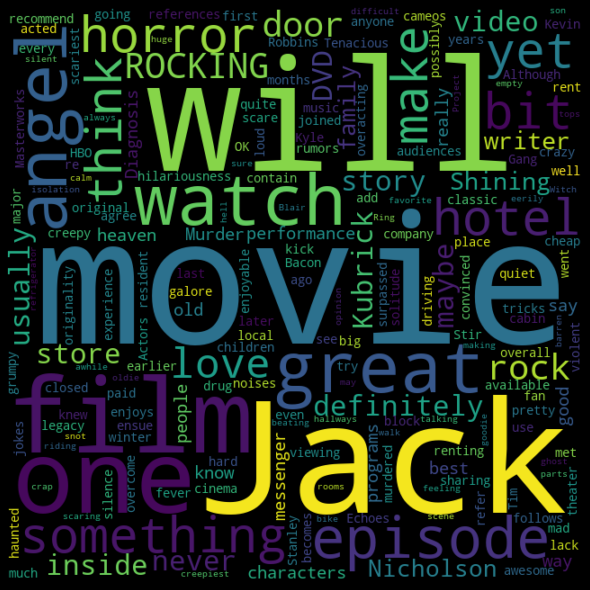

In [12]:
# Word cloud for positive reviews
comments = train_df['review'].loc[train_df['sentiment']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

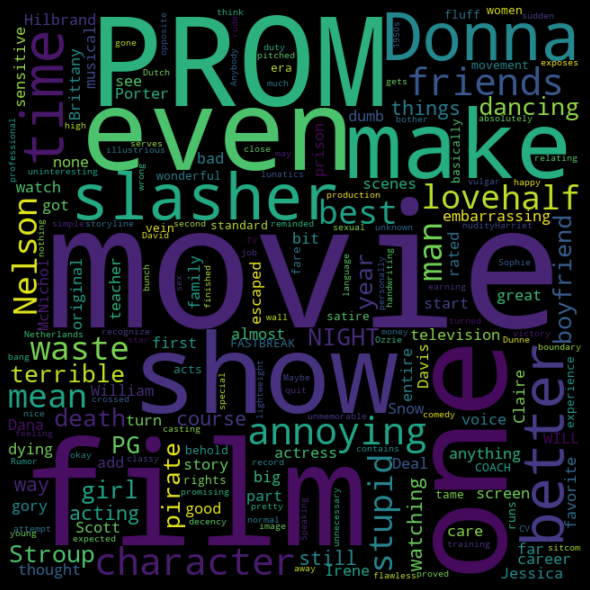

In [13]:
# Word cloud for negative reviews
comments = train_df['review'].loc[train_df['sentiment']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

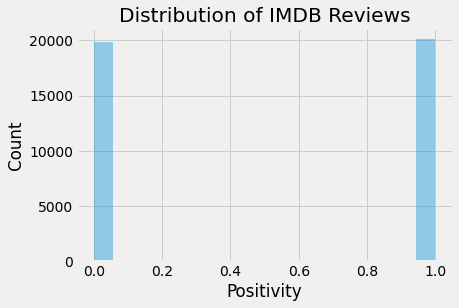

In [14]:
# Plot distribution of comments
fig = sns.distplot(train_df['sentiment'], kde=False)
plt.xlabel("Positivity")
plt.ylabel("Count")
plt.title("Distribution of IMDB Reviews")
plt.show(fig)

In [15]:
train_df['sentiment'].value_counts()

1    20119
0    19881
Name: sentiment, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [16]:
max_features = 20000
max_text_length = 400

In [17]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [18]:
# Save tokenizer for future use
with open('imdb_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [20]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [21]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [22]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

### Task 5: Build the Model

In [23]:
filters= 250
kernel_size=3
hidden_dims= 250

In [24]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

### Task 6: Compile Model

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Task 7: Splitting the data into training and validation set

In [26]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.3,random_state=1)

### Task 8: Model Fitting/Training

In [27]:
batch_size= 32
epochs = 3
hist = model.fit(x_train,y_train,
                    batch_size= batch_size,
                    epochs=epochs,
                    validation_data= (x_val,y_val)
                    )

Epoch 1/3
875/875 [==============================] - 9s 11ms/step - loss: 0.4690 - accuracy: 0.7654 - val_loss: 0.4432 - val_accuracy: 0.8034
Epoch 2/3
875/875 [==============================] - 9s 10ms/step - loss: 0.3526 - accuracy: 0.8450 - val_loss: 0.3150 - val_accuracy: 0.8665
Epoch 3/3
875/875 [==============================] - 9s 10ms/step - loss: 0.3152 - accuracy: 0.8634 - val_loss: 0.2968 - val_accuracy: 0.8739


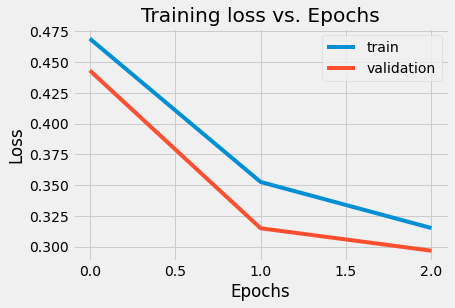

In [28]:
# Plot loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

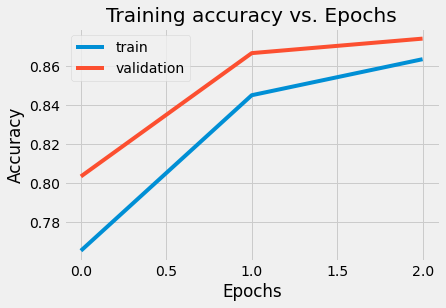

In [29]:
# Plot accuracy
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

### Task 9: Evaluate Model

In [30]:
test_df = pd.read_csv('data/imdb_test.csv')

In [31]:
x_test = test_df['review'].values
y_test = test_df['sentiment'].values

In [32]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [33]:
y_pred = model.predict(x_testing,verbose=1,batch_size=32)

313/313 [==============================] - 1s 4ms/step


In [34]:
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

In [35]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 88.86%


In [36]:
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))

F1 Score: 0.888564


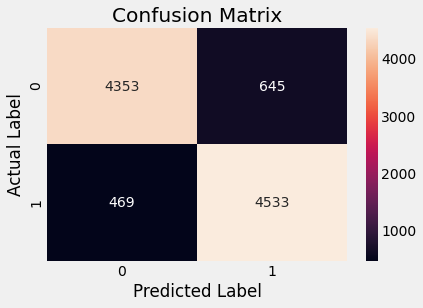

In [37]:
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

### Extras: View our results!

In [38]:
test_df['prediction'] = [ 'negative' if y == 0 else 'positive' for y in y_pred]

In [39]:
test_df.head(20)

,Unnamed: 0,review,sentiment,prediction
0,6961,This is a very fine and poetic story. Beautifu...,1,positive
1,17458,This has got to be the worst piece of crap I h...,0,negative
2,15880,If this is a 2008 product from one of the bigg...,0,negative
3,12565,Rose and the good Doctor find themselves in a ...,1,positive
4,42232,Just lovely. It is long. No climax. Don't wait...,1,positive
5,8534,This comedy is bound to be good from the get-g...,1,negative
6,33262,The worst thing about Crush is not that it's a...,0,negative
7,22705,This movie is one reason IMDB should allow a v...,0,negative
8,30267,"In this first episode of Friends, we are intro...",1,positive
9,38684,Like many here I grew up with Scooby-Doo. Unli...,1,positive


### Task 10: Save our model for future use

In [40]:
model.save('imdb_cnn.h5')